# AirBnB Dataset

table schemata [here](https://docs.google.com/document/d/1ezVFDe506zK1CuuNhNmzHEj_iNnL67hDrFzSap9V7S0/edit?usp=sharing) for the data

In [1]:
import urllib.request
import zipfile
import os

print("Starting download ...")
url = "https://github.com/aihack20/airbnb_challenge/releases/download/data/data-airbnb.zip"
with urllib.request.urlopen(url) as src:
    with open("tmp_airbnb_data.zip", "wb") as dest:
        dest.write(src.read())
print("Unpacking archive ...")
os.makedirs("airbnb_data", exist_ok=True)
with zipfile.ZipFile("tmp_airbnb_data.zip", compression=zipfile.ZIP_DEFLATED) as zip_f:
    zip_f.extractall("airbnb_data")
print("Done!")

Starting download ...
Unpacking archive ...
Done!


In [1]:
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype
from matplotlib import pyplot as plt
import numpy as np
import re
import random
import sklearn
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [2]:
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *

In [48]:
# Load the data (will take a short while)
calendar = pd.read_csv("airbnb_data/calendar.csv")
demographics = pd.read_csv("airbnb_data/demographics.csv")
econ_state = pd.read_csv("airbnb_data/econ_state.csv")
listings = pd.read_csv("airbnb_data/listings.csv")
real_estate = pd.read_csv("airbnb_data/real_estate.csv")
venues = pd.read_csv("airbnb_data/venues.csv")

## Data Cleaning

### Features with missing data deleted

In [49]:
percent_missing = listings.isnull().sum() * 100 / len(listings)
missing_listings_df = pd.DataFrame({'column_name': listings.columns,
                                 'percent_missing': percent_missing})

Text(0, 0.5, 'Percentage missing values')

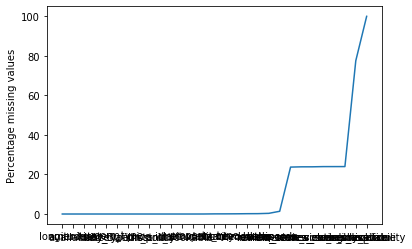

In [50]:
missing_listings_df.sort_values('percent_missing', inplace=True)
plt.plot(missing_listings_df['percent_missing'])
plt.ylabel('Percentage missing values')
# seems natural to drop those at the cutoff for around 20% missing data

In [51]:
cols_to_drop = ['has_availability', 'weekly_price', 'review_scores_value', 'review_scores_location', 'review_scores_checkin', 'review_scores_communication', 'review_scores_cleanliness', 'review_scores_rating', 'host_id', 'id', 'name', 'longitude', 'latitude']
listings_drop = listings.drop(columns=cols_to_drop)
listings_drop.head(4)

,accommodates,amenities,availability_30,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,instant_bookable,metropolitan,price,property_type,room_type,state,zipcode
0,2.0,"{""Cable TV"",""Wireless Internet"",""Air condition...",24,1.0,Real Bed,1.0,1.0,moderate,sunnysidebronx,f,NYC,99.0,House,Private room,NY,10464
1,4.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",30,1.0,Real Bed,1.0,1.0,flexible,sunnysidebronx,t,NYC,200.0,Apartment,Private room,NY,10464
2,4.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",30,3.0,Real Bed,3.0,3.0,strict,sunnysidebronx,f,NYC,300.0,House,Entire home/apt,NY,10464
3,3.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",8,1.0,Real Bed,1.0,1.0,strict,long island city,f,NYC,125.0,Apartment,Entire home/apt,NY,10464


### drop datapoints with nan

In [52]:
cols_to_delete_na = ['property_type', 'city', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'zipcode']
listings_drop = listings_drop.dropna(axis=0, subset=cols_to_delete_na)
listings_drop.head(4)

,accommodates,amenities,availability_30,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,instant_bookable,metropolitan,price,property_type,room_type,state,zipcode
0,2.0,"{""Cable TV"",""Wireless Internet"",""Air condition...",24,1.0,Real Bed,1.0,1.0,moderate,sunnysidebronx,f,NYC,99.0,House,Private room,NY,10464
1,4.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",30,1.0,Real Bed,1.0,1.0,flexible,sunnysidebronx,t,NYC,200.0,Apartment,Private room,NY,10464
2,4.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",30,3.0,Real Bed,3.0,3.0,strict,sunnysidebronx,f,NYC,300.0,House,Entire home/apt,NY,10464
3,3.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",8,1.0,Real Bed,1.0,1.0,strict,long island city,f,NYC,125.0,Apartment,Entire home/apt,NY,10464


In [53]:
# also drop amenities for now, zipcode back in to get extra features
listings_drop = listings_drop.drop(columns=['amenities'])

### use zipcode feature to tap into demographics data

In [54]:
unique_zips = set()

for z in listings_drop['zipcode']:
    
    z = z[:5]
    if z.isnumeric():
        unique_zips.add(int(z))

unique_zips_mask = list(unique_zips)

In [55]:
dem_key_df = demographics[demographics.zipcode.isin(unique_zips_mask)]
dem_key_df

,zipcode,5_years_or_less,5-9_years,10-14_years,15-19_years,20-24_years,25-34_years,35-44_years,45-54_years,55-59_years,...,"$10,000-$14,999","$15,000-$24,999","$25,000-$34,999","$35,000-$49,999","$50,000-$64,999","$65,000-$74,999","$75,000-$99,999","$100,000_or_more",median_household_income,mean_household_income
462,2108,4183,276,70,136,328,205,1072,627,489,...,7.4,1.2,3.6,4.5,8.4,6.8,12.9,28.1,103973,176335
463,2109,3947,134,46,46,36,295,1600,365,481,...,3.3,6.5,3.8,3.6,7.8,9.8,8.9,26.5,111313,166627
464,2110,2048,0,48,37,10,135,384,197,215,...,0.9,1.2,7,6.2,7.7,12.1,8.9,28.7,128210,240767
465,2111,7537,496,218,32,671,849,1769,755,895,...,17.9,6.5,10.7,6.7,6.8,12.9,6.2,25.9,51480,121824
466,2113,7221,131,46,68,7,997,3404,867,477,...,6.4,3,6.4,6.4,8.7,18,15.7,42.4,76503,95214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27888,80239,44561,3701,4334,4320,3422,3303,7330,7116,5141,...,6.7,3.8,9.7,13.6,17.5,21.1,16.5,55.1,48946,57565
27890,80246,13113,767,308,230,314,1811,4298,1660,1373,...,7.8,7.1,11.3,14.6,16.6,18.3,11.2,46.1,42102,59852
27891,80247,26827,1939,1117,1101,1143,1913,5762,3698,2764,...,7.4,7.4,14.5,15.2,17.6,18.1,10.5,46.2,39645,51380
27892,80249,28724,2434,2393,3013,2127,1751,4644,5321,3362,...,3.6,2.1,5.1,8.2,13,21.5,20.8,55.3,71882,76194


In [56]:
# filter by rows which have a zipcode that can be referenced in 'demographic'
mask = map(str, unique_zips_mask)
listings_drop = listings_drop[listings_drop.zipcode.isin(mask)]

In [57]:
listings_drop
# lost about 15k datapoints...

,accommodates,availability_30,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,instant_bookable,metropolitan,price,property_type,room_type,state,zipcode
0,2.0,24,1.0,Real Bed,1.0,1.0,moderate,sunnysidebronx,f,NYC,99.0,House,Private room,NY,10464
1,4.0,30,1.0,Real Bed,1.0,1.0,flexible,sunnysidebronx,t,NYC,200.0,Apartment,Private room,NY,10464
2,4.0,30,3.0,Real Bed,3.0,3.0,strict,sunnysidebronx,f,NYC,300.0,House,Entire home/apt,NY,10464
3,3.0,8,1.0,Real Bed,1.0,1.0,strict,long island city,f,NYC,125.0,Apartment,Entire home/apt,NY,10464
4,4.0,17,1.0,Real Bed,1.0,1.0,moderate,sunnysidebronx,t,NYC,69.0,House,Private room,NY,10464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59819,2.0,0,1.0,Real Bed,1.0,1.0,flexible,silver spring,t,dc,42.0,Apartment,Private room,MD,20910
59820,5.0,20,1.0,Real Bed,1.0,2.0,flexible,bethesda,f,dc,155.0,Apartment,Entire home/apt,MD,20816
59821,6.0,13,1.0,Real Bed,1.0,3.0,strict,temple hills,t,dc,75.0,House,Private room,MD,20748
59822,2.0,12,1.0,Real Bed,1.0,1.0,moderate,silver spring,t,dc,115.0,Condominium,Entire home/apt,MD,20910


In [58]:
def mean_income(row):
    
    zipcode = int(row['zipcode'])
    mean_income = demographics[demographics.zipcode.isin([zipcode])]['mean_household_income']
    if mean_income.empty:
        return np.nan
    else:
        return mean_income.item()
    
def median_income(row):
    
    zipcode = int(row['zipcode'])
    med_income = demographics[demographics.zipcode.isin([zipcode])]['median_household_income']
    if med_income.empty:
        return np.nan
    else:
        return med_income.item()

In [59]:
listings_drop['mean_household_income'] = listings_drop.apply(lambda row: mean_income(row), axis=1)
listings_drop['median_household_income'] = listings_drop.apply(lambda row: median_income(row), axis=1)

/Users/danielharris/anaconda3/envs/mlp/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: `item` has been deprecated and will be removed in a future version
  
/Users/danielharris/anaconda3/envs/mlp/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: `item` has been deprecated and will be removed in a future version


In [60]:
# now drop zipcode as we have squeezed what we want out
listings_drop = listings_drop.drop(columns=['zipcode'])
listings_drop = listings_drop[listings_drop.median_household_income != '-']
listings_drop = listings_drop[listings_drop.mean_household_income != '-']
listings_drop = listings_drop[listings_drop.median_household_income != '250,000+']
listings_drop = listings_drop.dropna(axis=0, subset=['median_household_income', 'mean_household_income'])

In [61]:
listings_drop.mean_household_income = listings_drop.mean_household_income.astype(float)
listings_drop.median_household_income = listings_drop.median_household_income.astype(float)

In [62]:
# chop off any datapoints with price > 1000
listings_drop = listings_drop[listings_drop.price < 1000]
# delete rows of price 0, which are -inf when taken log of price
listings_drop = listings_drop[listings_drop.price != 0]
listings_drop = listings_drop[listings_drop.mean_household_income > 0]
listings_drop = listings_drop[listings_drop.median_household_income > 0]

In [63]:
# also take log of these two price attributes
listings_drop['mean_household_income'] = np.log(listings_drop['mean_household_income'])
listings_drop['median_household_income'] = np.log(listings_drop['median_household_income'])

In [64]:
listings_drop_checkpoint = listings_drop

### Now standardise and one-hot encode etc. data

In [65]:
cols_to_scale = ['accommodates', 'availability_30', 'bathrooms', 'bedrooms', 'beds', 'median_household_income', 'mean_household_income']
scaler = StandardScaler()
listings_drop[cols_to_scale] = scaler.fit_transform(listings_drop[cols_to_scale])

In [66]:
listings_drop.head(4)

,accommodates,availability_30,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,instant_bookable,metropolitan,price,property_type,room_type,state,mean_household_income,median_household_income
0,-0.510986,1.624224,-0.372992,Real Bed,-0.273181,-0.552094,moderate,sunnysidebronx,f,NYC,99.0,House,Private room,NY,-0.027134,0.444016
1,0.497558,2.227195,-0.372992,Real Bed,-0.273181,-0.552094,flexible,sunnysidebronx,t,NYC,200.0,Apartment,Private room,NY,-0.027134,0.444016
2,0.497558,2.227195,3.928525,Real Bed,2.356919,1.236120,strict,sunnysidebronx,f,NYC,300.0,House,Entire home/apt,NY,-0.027134,0.444016
3,-0.006714,0.016301,-0.372992,Real Bed,-0.273181,-0.552094,strict,long island city,f,NYC,125.0,Apartment,Entire home/apt,NY,-0.027134,0.444016


In [67]:
df = listings_drop

## helper functions

In [68]:
def train_cats(df, cat_vars):
    # numercalize/categoricalize
    for name, col in df.items(): 
        if name in cat_vars:
            df[name] = col.cat.codes + 1
    df = pd.get_dummies(df, dummy_na=True)
    return df

In [69]:
cat_vars = ['bed_type', 'cancellation_policy', 'city', 'instant_bookable', 'metropolitan', 'property_type', 'room_type', 'state']
cont_vars = ['accommodates', 'availability_30', 'bathrooms', 'bedrooms', 'beds', 'median_household_income', 'mean_household_income']

In [70]:
for v in cat_vars: 
    df[v] = df[v].astype('category').cat.as_ordered()
df = train_cats(df, cat_vars)

In [71]:
df

,accommodates,availability_30,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,instant_bookable,metropolitan,price,property_type,room_type,state,mean_household_income,median_household_income
0,-0.510986,1.624224,-0.372992,5,-0.273181,-0.552094,3,84,1,1,99.0,14,2,5,-0.027134,0.444016
1,0.497558,2.227195,-0.372992,5,-0.273181,-0.552094,1,84,2,1,200.0,1,2,5,-0.027134,0.444016
2,0.497558,2.227195,3.928525,5,2.356919,1.236120,5,84,1,1,300.0,14,1,5,-0.027134,0.444016
3,-0.006714,0.016301,-0.372992,5,-0.273181,-0.552094,5,50,1,1,125.0,1,1,5,-0.027134,0.444016
4,0.497558,0.920758,-0.372992,5,-0.273181,-0.552094,3,84,2,1,69.0,14,2,5,-0.027134,0.444016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59818,-0.510986,2.026204,-0.372992,5,-0.273181,-0.552094,1,89,2,3,37.0,14,2,1,-1.364214,-1.336950
59819,-0.510986,-0.787660,-0.372992,5,-0.273181,-0.552094,1,75,2,3,42.0,1,2,3,0.123352,0.527831
59820,1.001830,1.222243,-0.372992,5,-0.273181,0.342013,1,9,1,3,155.0,1,1,3,2.146160,2.374802
59821,1.506102,0.518777,-0.372992,5,-0.273181,1.236120,5,86,2,3,75.0,14,2,3,-0.369572,0.024434


In [72]:
max(df['price'])

999.0

In [73]:
df.columns

Index(['accommodates', 'availability_30', 'bathrooms', 'bed_type', 'bedrooms',
       'beds', 'cancellation_policy', 'city', 'instant_bookable',
       'metropolitan', 'price', 'property_type', 'room_type', 'state',
       'mean_household_income', 'median_household_income'],
      dtype='object')

In [74]:
len(df.columns)

16

In [75]:
# calculate embedding sizes, so we can treat categorical features
for v in cat_vars: 
    df[v] = df[v].astype('category').cat.as_ordered()
cat_sz = [(c, len(df[c].cat.categories)+1) for c in cat_vars]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [76]:
cat_sz

[('bed_type', 6),
 ('cancellation_policy', 8),
 ('city', 94),
 ('instant_bookable', 3),
 ('metropolitan', 4),
 ('property_type', 28),
 ('room_type', 4),
 ('state', 6)]

In [77]:
emb_szs

[(6, 3), (8, 4), (94, 47), (3, 2), (4, 2), (28, 14), (4, 2), (6, 3)]

## split dataset

In [78]:
y = np.log(df['price'])
X = df.drop(columns=['price'])

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.99, random_state=42)

In [80]:
class ColumnarDataset(Dataset):
    """Dataset class for column dataset.
    Args:
       cats (list of str): List of the name of columns contain
                           categorical variables.
       conts (list of str): List of the name of columns which 
                           contain continuous variables.
       y (Tensor, optional): Target variables.
       is_reg (bool): If the task is regression, set ``True``, 
                      otherwise (classification) ``False``.
       is_multi (bool): If the task is multi-label classification, 
                        set ``True``.
    """
    def __init__(self, df, cat_flds, y, is_reg, is_multi):
        df_cat = df[cat_flds]
        df_cont = df.drop(cat_flds, axis=1)
        
        cats = [c.values for n,c in df_cat.items()]
        conts = [c.values for n,c in df_cont.items()]
        
        n = len(cats[0]) if cats else len(conts[0])
        self.cats = np.stack(cats, 1).astype(np.int64) if cats else np.zeros((n,1))
        self.conts = np.stack(conts, 1).astype(np.float32) if conts else np.zeros((n,1))
        self.y = np.zeros((n,1)) if y is None else y
        if is_reg: 
            self.y =  self.y[:,None]
        self.is_reg = is_reg
        self.is_multi = is_multi
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]

In [81]:
train_ds = ColumnarDataset(X_train, cat_vars, y_train, is_reg=True, is_multi=False)
val_ds = ColumnarDataset(X_val, cat_vars, y_val, is_reg=True, is_multi=False)
test_ds = ColumnarDataset(X_test, cat_vars, y_test, is_reg=True, is_multi=False)
bs = 64
train_dl = DataLoader(train_ds, bs, shuffle=True)
val_dl = DataLoader(val_ds, bs, shuffle=False)
test_dl = DataLoader(test_ds, len(X_test), shuffle=False)

In [82]:
class MixedInputModel(nn.Module):
    """Model able to handle inputs consisting of both categorical and continuous variables.
    Args:
       emb_szs (list of int): List of embedding size
       n_cont (int): Number of continuous variables in inputs
       emb_drop (float): Dropout applied to the output of embedding
       out_sz (int): Size of model's output.
       szs (list of int): List of hidden variables sizes
       drops (list of float): List of dropout applied to hidden 
                              variables
       y_range (list of float): Min and max of `y`. 
                                y_range[0] = min, y_range[1] = max.
       use_bn (bool): If use BatchNorm, set ``True``
       is_reg (bool): If regression, set ``True``
       is_multi (bool): If multi-label classification, set ``True``
    """
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, 
                 drops, y_range=None, use_bn=False, is_reg=True, 
                 is_multi=False):
        super().__init__()
        for i,(c,s) in enumerate(emb_szs): assert c > 1, f"cardinality must be >=2, got emb_szs[{i}]: ({c},{s})"
        if is_reg==False and is_multi==False: assert out_sz >= 2, "For classification with out_sz=1, use is_multi=True"
        self.embs = nn.ModuleList([nn.Embedding(c, s) 
                                      for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont=n_emb, n_cont
        
        szs = [n_emb+n_cont] + szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: kaiming_normal_(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        kaiming_normal_(self.outp.weight.data)
        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) 
                                        for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range
        self.is_reg = is_reg
        self.is_multi = is_multi
    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
            x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if not self.is_reg:
            if self.is_multi:
                x = torch.sigmoid(x)
            else:
                x = F.log_softmax(x, dim=1)
        elif self.y_range:
            x = torch.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        return x
def emb_init(x):
    x = x.weight.data
    sc = 2/(x.size(1)+1)
    x.uniform_(-sc,sc)

In [83]:
model = MixedInputModel(emb_szs, 
                        n_cont=len(X_train.columns)-len(cat_vars), 
                        emb_drop = 0.04, out_sz = 1, 
                        szs = [1000,500], drops = [0.001,0.01], 
                        y_range=(0,np.max(y_train)), use_bn=True, 
                        is_reg=True, is_multi=False)

In [84]:
losses = []
def train_model(model, train_dl, val_dl, n_epochs=1, lr=5e-2):
        "Run training loops."
        epochs = n_epochs
        opt = optim.SGD(model.parameters(), lr=lr)
        loss_func = nn.MSELoss()
        try:
            for epoch in range(epochs):
                model.train()
                for xb1, xb2, yb in train_dl:
                    preds = model(xb1, xb2)
                    loss = loss_func(preds, yb.float())
                    
                    loss.backward()
                    opt.step()
                    opt.zero_grad()
                    
                model.eval()
                with torch.no_grad():
                    loss_val = sum(loss_func(model(xv1, xv2), 
                                             yv.float()) 
                                   for xv1, xv2, yv in val_dl)
                print(epoch, loss_val / len(val_dl))
                losses.append(loss_val / len(val_dl))
            return model
        except Exception as e:
            exception = e
            raise

In [85]:
model = train_model(model, train_dl, val_dl, n_epochs=500, lr=5e-2)

0 tensor(7.3267)
1 tensor(5.6701)
2 tensor(5.2657)
3 tensor(5.5164)
4 tensor(6.4390)
5 tensor(5.6861)
6 tensor(6.0492)
7 tensor(5.8458)
8 tensor(5.2276)
9 tensor(5.2107)
10 tensor(8.4315)
11 tensor(5.8162)
12 tensor(6.4827)
13 tensor(6.8484)
14 tensor(6.7949)
15 tensor(7.1577)
16 tensor(5.4719)
17 tensor(6.3813)
18 tensor(6.2866)
19 tensor(7.7250)
20 tensor(7.2656)
21 tensor(5.2150)
22 tensor(5.3636)
23 tensor(11.3974)
24 tensor(7.3625)
25 tensor(6.5931)
26 tensor(5.6382)
27 tensor(6.0570)
28 tensor(5.2254)
29 tensor(4.7859)
30 tensor(5.7566)
31 tensor(5.0257)
32 tensor(5.0809)
33 tensor(12.5567)
34 tensor(10.2196)
35 tensor(5.9967)
36 tensor(9.1871)
37 tensor(4.4896)
38 tensor(4.4597)
39 tensor(5.1622)
40 tensor(8.0294)
41 tensor(4.2225)
42 tensor(4.4782)
43 tensor(6.4741)
44 tensor(6.9561)
45 tensor(5.8536)
46 tensor(5.4336)
47 tensor(5.6004)
48 tensor(3.7376)
49 tensor(13.1333)
50 tensor(4.3764)
51 tensor(4.3996)
52 tensor(5.1249)
53 tensor(4.2474)
54 tensor(3.9694)
55 tensor(5.4848

437 tensor(0.6502)
438 tensor(0.7878)
439 tensor(0.7373)
440 tensor(0.7265)
441 tensor(1.3482)
442 tensor(1.3579)
443 tensor(0.7452)
444 tensor(0.7635)
445 tensor(0.5556)
446 tensor(0.5348)
447 tensor(1.2124)
448 tensor(0.9219)
449 tensor(1.0723)
450 tensor(0.7755)
451 tensor(0.7445)
452 tensor(0.6521)
453 tensor(1.0380)
454 tensor(1.4520)
455 tensor(0.8079)
456 tensor(0.8214)
457 tensor(0.9121)
458 tensor(0.7313)
459 tensor(0.6595)
460 tensor(0.5536)
461 tensor(1.0934)
462 tensor(0.9797)
463 tensor(0.9458)
464 tensor(0.7596)
465 tensor(0.6905)
466 tensor(0.7007)
467 tensor(0.8326)
468 tensor(0.7262)
469 tensor(0.6409)
470 tensor(1.0182)
471 tensor(0.8521)
472 tensor(0.8025)
473 tensor(0.6666)
474 tensor(0.6289)
475 tensor(0.7948)
476 tensor(0.6356)
477 tensor(0.9849)
478 tensor(1.0019)
479 tensor(0.9421)
480 tensor(1.2205)
481 tensor(0.7755)
482 tensor(0.9492)
483 tensor(0.8779)
484 tensor(0.7858)
485 tensor(0.8768)
486 tensor(0.7828)
487 tensor(1.0376)
488 tensor(1.1466)
489 tensor(1

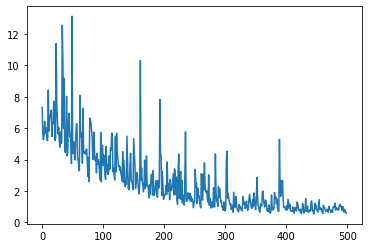

In [86]:
plt.plot(list(range(len(losses))), losses)

In [87]:
def predict_test(model, test_dl):
    "Returns predictions over test_df."
    model.eval()
    
    preds = []
    for xv1, xv2, _ in test_dl:
        pred = model(xv1, xv2)
        preds.append(pred)
        if pred[0].data.detach().numpy() == 0:
            print(xv1, xv2)
        
    
    #preds = [model(xv1, xv2) for xv1, xv2, _ in test_dl][0]
    targs = [yv for _, _, yv in test_dl][0]
    
    return preds[0].data.detach().numpy(), targs.data.detach().numpy()

In [88]:
preds, targs = predict_test(model, test_dl)

In [89]:
counter = 0
for i in preds:
    if i < 1:
        counter +=1
counter / len(preds)

0.0

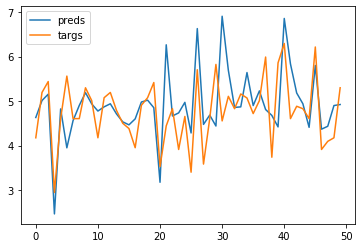

In [93]:
plt.plot(range(len(targs[550:600])), preds[550:600], label='preds')
plt.plot(range(len(targs[550:600])), targs[550:600], label='targs')
plt.legend()

(array([3.864e+03, 4.010e+03, 3.834e+03, 3.546e+03, 3.125e+03, 2.608e+03,
        2.256e+03, 1.699e+03, 1.295e+03, 9.760e+02, 7.360e+02, 5.710e+02,
        5.170e+02, 4.130e+02, 3.350e+02, 3.200e+02, 3.110e+02, 2.430e+02,
        2.130e+02, 2.190e+02, 1.720e+02, 1.570e+02, 1.570e+02, 1.380e+02,
        1.300e+02, 1.170e+02, 1.080e+02, 9.500e+01, 8.400e+01, 9.800e+01,
        7.400e+01, 6.500e+01, 7.500e+01, 7.800e+01, 7.400e+01, 6.500e+01,
        7.900e+01, 5.000e+01, 4.200e+01, 6.600e+01, 4.900e+01, 5.200e+01,
        4.900e+01, 5.100e+01, 5.100e+01, 2.900e+01, 2.400e+01, 3.900e+01,
        3.700e+01, 4.700e+01, 5.300e+01, 3.100e+01, 2.600e+01, 3.900e+01,
        4.400e+01, 3.000e+01, 2.600e+01, 2.600e+01, 2.700e+01, 2.300e+01,
        3.600e+01, 2.900e+01, 3.000e+01, 2.200e+01, 3.300e+01, 3.200e+01,
        2.700e+01, 2.400e+01, 2.200e+01, 2.900e+01, 2.800e+01, 2.400e+01,
        2.300e+01, 1.600e+01, 2.100e+01, 3.200e+01, 1.500e+01, 1.900e+01,
        1.000e+01, 2.100e+01, 2.600e+0

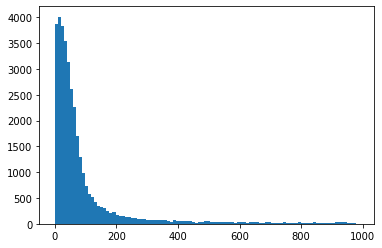

In [95]:
plt.hist(np.abs((np.exp(preds)-np.exp(targs))), bins=100)

(array([2.500e+01, 1.500e+02, 6.700e+02, 1.840e+03, 3.109e+03, 2.968e+03,
        3.135e+03, 3.248e+03, 2.682e+03, 3.839e+03, 1.569e+03, 1.879e+03,
        2.045e+03, 1.230e+03, 2.511e+03, 8.010e+02, 7.630e+02, 1.302e+03,
        6.410e+02, 1.886e+03, 2.310e+02, 3.740e+02, 5.670e+02, 2.180e+02,
        1.160e+03, 1.560e+02, 1.080e+02, 3.310e+02, 1.490e+02, 7.920e+02,
        5.300e+01, 7.100e+01, 1.470e+02, 5.700e+01, 3.910e+02, 4.100e+01,
        2.600e+01, 1.100e+02, 4.900e+01, 3.810e+02, 1.900e+01, 1.900e+01,
        6.300e+01, 2.100e+01, 1.730e+02, 1.300e+01, 9.000e+00, 4.000e+01,
        1.900e+01, 3.400e+02, 4.000e+00, 6.000e+00, 2.700e+01, 5.000e+00,
        8.700e+01, 1.600e+01, 5.000e+00, 3.300e+01, 1.300e+01, 1.820e+02,
        1.000e+00, 3.000e+00, 6.000e+00, 1.000e+00, 6.700e+01, 2.000e+00,
        1.000e+00, 9.000e+00, 3.000e+00, 8.500e+01, 2.000e+00, 2.000e+00,
        6.000e+00, 3.000e+00, 5.400e+01, 0.000e+00, 3.000e+00, 5.000e+00,
        4.000e+00, 1.900e+01, 8.700e+0

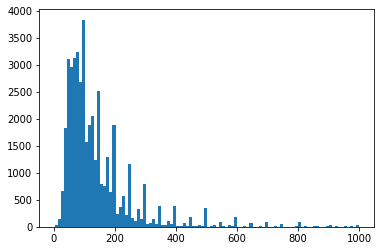

In [96]:
plt.hist(df['price'].values, bins=100)

In [91]:
def rmse(pred, targ):
    return np.sqrt(np.mean((pred-targ)**2))

In [92]:
rmse(preds, targs)

0.76946654539517